In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import warnings
from datetime import datetime
from functions import *
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

env: KMP_DUPLICATE_LIB_OK=TRUE


## G-learning for wealth optimization

The purpose of this notebook is to demonstrate the use of G-learning with quadratic rewards for optimization of a defined contribution retirement plan.

#### Define the G-learning portfolio optimization class

In [3]:
class G_learning_portfolio_opt:
    def __init__(self,
                 num_steps,
                 params,
                 beta,
                 benchmark_portf,
                 gamma,
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns,  # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky assets
                 init_x_vals,  # array of initial asset position values (num_risky_assets + 1)
                 use_for_WM = True):  # use for wealth management tasks

        self.num_steps = num_steps
        self.num_assets = num_risky_assets + 1

        self.lambd = torch.tensor(params[0], requires_grad=False, dtype=torch.float64)
        self.Omega_mat = params[1] * torch.eye(self.num_assets, dtype=torch.float64)
        self.eta = torch.tensor(params[2], requires_grad=False, dtype=torch.float64)
        self.rho = torch.tensor(params[3], requires_grad=False, dtype=torch.float64)
        self.beta = torch.tensor(beta, requires_grad=False, dtype=torch.float64)

        self.gamma = gamma
        self.use_for_WM = use_for_WM

        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate


        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets  # self.num_assets

        self.Sigma_r_np = Sigma_r  # array of shape num_stocks x num_stocks

        self.reg_mat = 1e-3*torch.eye(self.num_assets, dtype=torch.float64)

        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1)
        self.exp_returns_np = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))

        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde_np = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde_np[1:,1:] = self.Sigma_r_np

        # make Torch tensors
        self.exp_returns = torch.tensor(self.exp_returns_np, requires_grad=False, dtype=torch.float64)
        self.Sigma_r = torch.tensor(Sigma_r, requires_grad=False, dtype=torch.float64)
        self.Sigma_r_tilde = torch.tensor(self.Sigma_r_tilde_np, requires_grad=False, dtype=torch.float64)

        self.benchmark_portf = torch.tensor(benchmark_portf, requires_grad=False, dtype=torch.float64)

        # asset holding values for all times. Initialize with initial values,
        # values for the future times will be expected values
        self.x_vals_np = np.zeros((self.num_steps, self.num_assets))
        self.x_vals_np[0,:] = init_x_vals

        # Torch tensor
        self.x_vals = torch.tensor(self.x_vals_np)

        # allocate memory for coefficients of R-, F- and G-functions
        self.F_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.F_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64,
                               requires_grad=False)
        self.F_0 = torch.zeros(self.num_steps, dtype=torch.float64, requires_grad=False)

        self.Q_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.Q_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.Q_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.Q_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64, requires_grad=False)
        self.Q_u = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64, requires_grad=False)
        self.Q_0 = torch.zeros(self.num_steps, dtype=torch.float64, requires_grad=False)

        self.R_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.R_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.R_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=False)
        self.R_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64, requires_grad=False)
        self.R_u = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64, requires_grad=False)
        self.R_0 = torch.zeros(self.num_steps, dtype=torch.float64, requires_grad=False)


        self.reset_prior_policy()

        # the list of adjustable model parameters:
        self.model_params = [self.lambd, self.beta, self.Omega_mat, self.eta]

        # expected cash installment for all steps
        self.expected_c_t = torch.zeros(self.num_steps, dtype=torch.float64)

        # realized values of the target portfolio
        self.realized_target_portf = np.zeros(self.num_steps, dtype=np.float64)

        # expected portfolio values for all times
        self.expected_portf_val = torch.zeros(self.num_steps, dtype=torch.float64)

        # the first value is the sum of initial position values
        self.expected_portf_val[0] = self.x_vals[0,:].sum()

    def reset_prior_policy(self):
        # initialize time-dependent parameters of prior policy
        self.u_bar_prior = torch.zeros(self.num_steps, self.num_assets, requires_grad=False,
                                       dtype=torch.float64)
        self.v_bar_prior = torch.zeros(self.num_steps, self.num_assets, self.num_assets, requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior = torch.zeros(self.num_steps, self.num_assets, self.num_assets, requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior_inv = torch.zeros(self.num_steps, self.num_assets, self.num_assets, requires_grad=False,
                                           dtype=torch.float64)

        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior_inv[t,:,:] = 10.0 * torch.eye(self.num_assets).clone()  # np.linalg.inv(self.Sigma_prior[t,:,:])

    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function
        """
        x_plus = x_vals + u_vals

        p_hat = self.rho.clone() * self.benchmark_portf[t] + (1-self.rho.clone())*self.eta.clone()*x_vals.sum()

        aux_1 = - self.lambd.clone() * p_hat**2
        aux_2 = - u_vals.sum()
        aux_3 = 2*self.lambd.clone() * p_hat * x_plus.dot(torch.ones(self.num_assets) + exp_rets)
        aux_4 = - self.lambd.clone() * x_plus.mm(Sigma_hat.mv(x_plus))
        aux_5 = - u_vals.mm(self.Omega_mat.clone().mv(u_vals))

        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5

    def compute_reward_fun(self):
        """
        Compute coefficients R_xx, R_ux, etc. for all steps
        """
        for t in range(0, self.num_steps):
            
            # Formula (23)
            one_plus_exp_ret = torch.ones(self.num_assets, dtype=torch.float64) + self.exp_returns[t,:]
            benchmark_portf = self.benchmark_portf[t]
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)

            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret, torch.ones(self.num_assets, dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()
            one_one_T_mat = torch.ones(self.num_assets, self.num_assets)
            
            
            self.R_xx[t,:,:] = (-self.lambd.clone()*(self.eta.clone()**2)*(self.rho.clone()**2)*one_one_T_mat
                                + 2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                - self.lambd.clone()*Sigma_hat)

            self.R_ux[t,:,:] = (2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                - 2*self.lambd.clone()*Sigma_hat)

            self.R_uu[t,:,:] = - self.lambd.clone() * Sigma_hat - self.Omega_mat.clone()

            self.R_x[t,:] = (-2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*(1-self.rho.clone())*benchmark_portf *
                             torch.ones(self.num_assets, dtype=torch.float64)
                             + 2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret)

            self.R_u[t,:] = (2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret
                             - torch.ones(self.num_assets, dtype=torch.float64))

            self.R_0[t] = - self.lambd.clone()*((1-self.rho.clone())**2) * (benchmark_portf**2)

    def project_cash_injections(self):
        """
        Compute the expected values of future asset positions, and the expected cash injection for future steps,
        as well as realized values of the target portfolio
        """

        # this assumes that the policy is trained
        for t in range(1, self.num_steps):  # the initial value is fixed
            # increment the previous x_t
            # (Formula (34))
            delta_x_t = self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].mv(self.x_vals[t-1,:])
            self.x_vals[t,:] = self.x_vals[t-1,:] + delta_x_t

            # grow using the expected return
            self.x_vals[t,:] = (torch.ones(self.num_assets) + self.exp_returns[t,:])*self.x_vals[t,:]

            # compute c_t
            self.expected_c_t[t] = delta_x_t.sum().data  # detach().numpy()

            # expected portfolio value for this step
            self.expected_portf_val[t] = self.x_vals[t,:].sum().data  # .detach().numpy()

    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """

        # the auxiliary quantity to perform matrix calculations
        one_plus_exp_ret = torch.ones(self.num_assets, dtype=torch.float64) + self.exp_returns[-1,:]

        # Compute the reward function for all steps (only the last step is needed for this functions, while
        # values for other time steps will be used in other functions)
        self.compute_reward_fun()

        if self.use_for_WM:
            # Formula (23)
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            Sigma_hat_inv = torch.inverse(Sigma_hat + self.reg_mat)
            
            # Formula (27)
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat.clone()
            Sigma_tilde_inv = torch.inverse(Sigma_tilde + self.reg_mat)

            Sigma_hat_sigma_tilde = Sigma_hat.mm(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.mm(Sigma_hat)
            Sigma_tilde_sigma_hat = Sigma_tilde.mm(Sigma_hat)

            Sigma_hat_Sigma_tilde_inv = Sigma_hat.mm(Sigma_tilde_inv)
            Sigma_3_plus_omega = self.lambd*Sigma_tilde_inv.mm(Sigma_hat_Sigma_tilde_inv) + self.Omega_mat.clone()

            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret, torch.ones(self.num_assets, dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()
            one_one_T_mat = torch.ones(self.num_assets, self.num_assets)

            Sigma_tilde_inv_t_R_ux = Sigma_tilde_inv.t().mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.t().mm(self.R_uu[-1,:,:].clone())
            Sigma_tilde_inv_t_R_u = Sigma_tilde_inv.t().mv(self.R_u[-1,:].clone())

            Sigma_tilde_inv_R_u = Sigma_tilde_inv.mv(self.R_u[-1,:].clone())
            Sigma_tilde_inv_R_ux = Sigma_tilde_inv.mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.mm(self.R_uu[-1,:,:].clone())

            # though the action at the last step is deterministic, we can feed
            # parameters of the prior with these values
            
            # Formula (26)
            self.u_bar_prior[-1,:] = (1/(2 * self.lambd.clone())) * Sigma_tilde_inv.clone().mv(self.R_u[-1,:].clone())
            self.v_bar_prior[-1,:,:] = (1/(2 * self.lambd.clone())) * Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())

            # First compute the coefficients of the reward function F at the last step:
            # Formula (28)
            # F_xx
            self.F_xx[-1,:,:] = (self.R_xx[-1,:,:].clone()
                                 + (1/(2*self.lambd.clone())) * self.R_ux[-1,:,:].clone().t().mm(Sigma_tilde_inv_t_R_ux)
                                 + (1/(4*self.lambd.clone()**2)) * self.R_ux[-1,:,:].clone().t().mm(
                        Sigma_tilde_inv_t_R_uu.clone().mm(Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())))
                                 )

            # F_x
            self.F_x[-1,:] = (self.R_x[-1,:].clone()
                              + (1/(self.lambd.clone())) * self.R_ux[-1,:,:].clone().t().mv(Sigma_tilde_inv_t_R_u.clone())
                              + (1/(2*self.lambd.clone()**2)) * self.R_ux[-1,:,:].clone().t().mv(
                        Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                              )

            # F_0
            self.F_0[-1] = (self.R_0[-1].clone()
                            + (1/(2*self.lambd.clone())) * self.R_u[-1,:].clone().dot(Sigma_tilde_inv_R_u.clone())
                            + (1/(4*self.lambd.clone()**2)) * self.R_u[-1,:].clone().dot(
                        Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                            )

            # for the Q-function at the last step:
            # Formula (31)
            self.Q_xx[-1,:,:] = self.R_xx[-1,:,:].clone()
            self.Q_ux[-1,:,:] = self.R_ux[-1,:,:].clone()
            self.Q_uu[-1,:,:] = self.R_uu[-1,:,:].clone()
            self.Q_u[-1,:] = self.R_u[-1,:].clone()
            self.Q_x[-1,:] = self.R_x[-1,:].clone()
            self.Q_0[-1] = self.R_0[-1].clone()

    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy

        """
#         print('Doing G-learning, it may take a few seconds...')

        # set terminal conditions
        self.set_terminal_conditions()

        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)

        # iterate over time steps backward
        for t in range(self.num_steps-2, -1, -1):
            self.step_G_learning(t, err_tol, max_iter)

    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """

        # make matrix Sigma_hat_t
        # Formula (23)
        one_plus_exp_ret = torch.ones(self.num_assets, dtype=torch.float64) + self.exp_returns[t,:]
        Sigma_hat_t = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)

        # matrix A_t = diag(1 + r_bar_t)
        # Formula (25)
        A_t = torch.diag(torch.ones(self.num_assets, dtype=torch.float64) + self.exp_returns[t,:])

        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t, Sigma_hat_t)

        # iterate between policy evaluation and policy improvement
        while self.iter_counts[t] < max_iter:

            curr_u_bar_prior = self.u_bar_prior[t,:].clone()
            curr_v_bar_prior = self.v_bar_prior[t,:,:].clone()

            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t)

            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)

            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = torch.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)

            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*torch.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)

            # choose the difference from the previous iteration as the maximum of the two errors
            tol = torch.max(err_u_bar, err_v_bar)  # tol = 0.5*(err_u_bar + err_v_bar)

            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break

    def update_Q_params(self, t, A_t, Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """
        
        # Formula (31)
        ones = torch.ones(self.num_assets, dtype=torch.float64)
        one_plus_exp_ret = torch.ones(self.num_assets, dtype=torch.float64) + self.exp_returns[t,:]

        self.Q_xx[t,:,:] = (self.R_xx[t,:,:].clone()
                            + self.gamma *((A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())
                                            + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone()))


        self.Q_ux[t,:,:] = (self.R_ux[t,:,:].clone()
                            + 2 * self.gamma * ((A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())
                                                + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone())
                            )

        self.Q_uu[t,:,:] = (self.R_uu[t,:,:].clone()
                            + self.gamma * ((A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())
                                            + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone())
                            - self.Omega_mat.clone()
                            )


        self.Q_x[t,:] = self.R_x[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone())
        self.Q_u[t,:] = self.R_u[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone())
        self.Q_0[t] = self.R_0[t].clone() + self.gamma * self.F_0[t+1].clone()

    def update_F_params(self, t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy

        """

        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        # Formula (37)
        U_t = (self.beta.clone() * self.Q_ux[t,:,:].clone()
               + self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone()))
        W_t = (self.beta.clone() * self.Q_u[t,:].clone()
               + self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:]).clone())
        Sigma_p_bar = self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()
        Sigma_p_bar_inv = torch.inverse(Sigma_p_bar + self.reg_mat)

        # update parameters of F-function
        # Formula (36)
        self.F_xx[t,:,:] = self.Q_xx[t,:,:].clone() + (1/(2*self.beta.clone()))*(U_t.t().mm(Sigma_p_bar_inv.clone().mm(U_t))
                                                                                 - self.v_bar_prior[t,:,:].clone().t().mm(
                    self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())))


        self.F_x[t,:] = self.Q_x[t,:].clone() + (1/self.beta.clone())*(U_t.mv(Sigma_p_bar_inv.clone().mv(W_t))
                                                                       - self.v_bar_prior[t,:,:].clone().mv(
                    self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))


        self.F_0[t] = self.Q_0[t].clone() + ((1/(2*self.beta.clone()))*(W_t.dot(Sigma_p_bar_inv.clone().mv(W_t))
                                                                        - self.u_bar_prior[t,:].clone().dot(
                    self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))
                                              - (1/(2*self.beta.clone())) * (torch.log(torch.det(self.Sigma_prior[t,:,:].clone() +
                                                                                                 self.reg_mat))
                                                                             - torch.log(torch.det(Sigma_p_bar_inv.clone() + self.reg_mat))))

    def update_policy_params(self, t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """

        # Formula (40)
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()

        Sigma_prior_new = torch.inverse(new_Sigma_prior_inv + self.reg_mat)

        # update parameters using the previous value of Sigma_prior_inv
        # Formula (40)
        self.u_bar_prior[t,:] = Sigma_prior_new.mv(self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())
                                                   + self.beta.clone() * self.Q_u[t,:].clone())


        self.v_bar_prior[t,:,:] = Sigma_prior_new.clone().mm(self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())
                                                             + self.beta.clone() * self.Q_ux[t,:,:].clone())

        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new.clone()
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv.clone()

        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:].clone()
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:].clone()
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:].clone()

    def trajs_to_torch_tensors(self, trajs):
        """
        Convert data from a list of lists into Torch tensors
        """
        num_trajs = len(trajs)

        self.data_xvals = torch.zeros(num_trajs, self.num_steps, self.num_assets, dtype=torch.float64)
        self.data_uvals = torch.zeros(num_trajs, self.num_steps, self.num_assets, dtype=torch.float64)

        for n in range(num_trajs):
            for t in range(self.num_steps):
                self.data_xvals[n,t,:] = torch.tensor(trajs[n][t][0], dtype=torch.float64).clone()
                self.data_uvals[n,t,:] = torch.tensor(trajs[n][t][1], dtype=torch.float64).clone()

    def compute_reward_on_traj(self,
                               t,
                               x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        # Formula (23)
        aux_xx = x_t.dot(self.R_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.R_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.R_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.R_x[t,:].clone())
        aux_u = u_t.dot(self.R_u[t,:].clone())
        aux_0 = self.R_0[t].clone()

        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0

    def compute_G_fun_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        # Formula (30)
        aux_xx = x_t.dot(self.Q_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.Q_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.Q_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.Q_x[t,:].clone())
        aux_u = u_t.dot(self.Q_u[t,:].clone())
        aux_0 = self.Q_0[t].clone()

        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0

    def compute_F_fun_on_traj(self,
                              t,
                              x_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        # Formula (36)
        aux_xx = x_t.dot(self.F_xx[t,:,:].clone().mv(x_t))
        aux_x = x_t.dot(self.F_x[t,:].clone())
        aux_0 = self.F_0[t].clone()

        return aux_xx + aux_x + aux_0

    def MaxEntIRL(self,
                  trajs,
                  learning_rate,
                  err_tol, max_iter):

        """
        Estimate parameters of the reward function using MaxEnt IRL.
        Inputs:

        trajs - a list of trajectories. Each trajectory is a list of state-action pairs, stored as a tuple.
                We assume each trajectory has the same length
        """

        # omega is a tunable parameter that determines the cost matrix self.Omega_mat
        omega_init = 15.0
        self.omega = torch.tensor(omega_init, requires_grad=True, dtype=torch.float64)

        beta_init = 50  # Beta is fixed and not a learned parameter.
        self.beta = torch.tensor(beta_init, requires_grad=True, dtype=torch.float64)

        reward_params = [self.lambd, self.eta, self.rho, self.omega, self.beta]

        print("Omega mat...")
        self.Omega_mat = self.omega * torch.eye(self.num_assets, dtype=torch.float64)
        print("g learning...")
        self.reset_prior_policy()
        self.G_learning(err_tol, max_iter)
        print("intialize optimizer...")
        optimizer = optim.Adam(reward_params, lr=learning_rate)
        print("zero grad...")
        optimizer.zero_grad()

        num_trajs = len(trajs)
        print("trajs_to_torch_tensors...")

        # fill in Torch tensors for the trajectory data
        self.trajs_to_torch_tensors(trajs)
        print("constructing zero tensors...")
        self.realized_rewards = torch.zeros(num_trajs, self.num_steps, dtype=torch.float64, requires_grad=True)
        self.realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")
        self.realized_G_fun = torch.zeros(num_trajs, self.num_steps, dtype=torch.float64, requires_grad=True)
        self.realized_F_fun = torch.zeros(num_trajs, self.num_steps, dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")
        self.realized_G_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=True)
        self.realized_F_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=True)
        print("done...")

        num_iter_IRL = 3

        for i in range(num_iter_IRL):
            print('GIRL iteration = ', i)

            self.Omega_mat = self.omega * torch.eye(self.num_assets, dtype=torch.float64)

            for n in range(101):
                if n % 100 == 0:
                    print(n)
                for t in range(self.num_steps):

                    # compute rewards obtained at each step for each trajectory
                    # given the model parameters
                    self.realized_rewards[n,t] = self.compute_reward_on_traj(t,
                                                                             self.data_xvals[n,t,:],
                                                                             self.data_uvals[n,t,:])

                    # compute the log-likelihood by looping over trajectories
                    self.realized_G_fun[n,t] = self.compute_G_fun_on_traj(t,
                                                                          self.data_xvals[n,t,:],
                                                                          self.data_uvals[n,t,:])

                    self.realized_F_fun[n,t] = self.compute_F_fun_on_traj(t,
                                                                          self.data_xvals[n,t,:])

                self.realized_cum_rewards[n] = self.realized_rewards[n,:].sum().clone()
                self.realized_G_fun_cum[n] = self.realized_G_fun[n,:].sum().clone()
                self.realized_F_fun_cum[n] = self.realized_F_fun[n,:].sum().clone()

            # the negative log-likelihood will not include terms ~ Sigma_p as we do not optimize over its value
            loss = - self.beta.clone()*(self.realized_G_fun_cum.sum().clone() - self.realized_F_fun_cum.sum().clone())

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            print('Iteration = ', i)
            print('Loss = ', loss.detach().numpy())

        print('Done optimizing reward parameters')

#### Define the function to compute returns

In [4]:
def rt_calculate(df):
    rt = pd.DataFrame(columns=df.columns, index=df.index)
    rt.iloc[1:] = df.diff(1).iloc[1:] / df.values[:-1]
    return rt

#### Extract and process the stock data and compute returns

In [5]:
df = pd.read_csv('D:\\SBU (Local)\\Courses Data\\AMS 520\\stock_processed.csv', index_col=0)
df.index = list(map(lambda x: datetime.strptime(x, '%m/%d/%Y').date(), df.index))
df = df[[True]+list(map(lambda x, y: x.month != y.month, df.index[:-1], df.index[1:]))]
risky_asset_returns = rt_calculate(df).iloc[1:].astype(float)
print(risky_asset_returns.shape)
print(risky_asset_returns.iloc[:,:6].head())

(68, 50)
                 AAL      AAPL      ADXS      AMAT       AMC       AMD
2016-02-01 -0.037399 -0.084670 -0.256111 -0.044396 -0.079845 -0.227437
2016-03-01  0.065202  0.048130 -0.157143  0.103379  0.166979  0.018692
2016-04-01 -0.055224  0.094101  0.569492  0.105834  0.160084  0.298165
2016-05-02 -0.126265 -0.148650 -0.157667 -0.051821  0.008729  0.321555
2016-06-01 -0.072030  0.057902  0.210256  0.205504  0.001385  0.184492


We choose 12 months time horizon, and obtain expected returns in terms of 36 months rolling mean

In [6]:
T, num_risky_assets = risky_asset_returns.shape
t_out = 12
t_in = min(36, T-t_out)
expected_risky_returns = np.tile(risky_asset_returns.iloc[-t_in-t_out:-t_out].mean().values, (t_out, 1))
Sigma_r = risky_asset_returns.iloc[-t_in-t_out:-t_out].cov().values
print(expected_risky_returns)

[[-0.02366099  0.03998834 -0.08321639  0.01525802  0.00516128  0.07049143
   0.02013312  0.00803947  0.00076967  0.01267981 -0.0022502   0.00403507
   0.00307555  0.00452402  0.00216258 -0.00330525  0.02111001 -0.03608041
   0.02032976  0.00426875  0.01916446 -0.0287244   0.00379093  0.01569621
   0.00738243  0.0258356   0.00824955 -0.00077479  0.03476866  0.01697595
  -0.07843434 -0.00080361  0.00661429  0.01437723  0.00726413  0.02296239
  -0.02651766  0.00525718  0.01641728  0.0132616  -0.07297105  0.00057169
   0.03733004 -0.02517773 -0.00849937  0.00747336  0.00456591 -0.00575661
   0.00498453  0.02923604]
 [-0.02366099  0.03998834 -0.08321639  0.01525802  0.00516128  0.07049143
   0.02013312  0.00803947  0.00076967  0.01267981 -0.0022502   0.00403507
   0.00307555  0.00452402  0.00216258 -0.00330525  0.02111001 -0.03608041
   0.02032976  0.00426875  0.01916446 -0.0287244   0.00379093  0.01569621
   0.00738243  0.0258356   0.00824955 -0.00077479  0.03476866  0.01697595
  -0.078434

#### Make the initial portfolio

In [7]:
init_cash = 1000
dt = 1/12
riskfree_rate = 0.02*dt

num_assets = num_risky_assets + 1
num_steps = t_out
x_vals_init = init_cash * np.ones(num_assets) / num_assets

#### Make the target portfolio

1068.9391057472465 2225.5409284924694


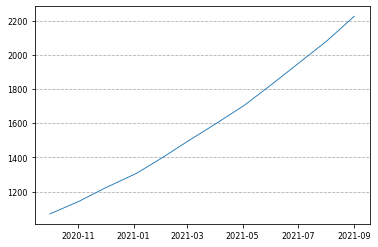

In [8]:
target_return = 0.8
benchmark_portf = [init_cash * np.exp(dt * target_return)]
for i in range(1, num_steps):
    benchmark_portf.append(benchmark_portf[i-1]*np.exp(dt * target_return))
print(benchmark_portf[0], benchmark_portf[-1])
plt.grid(axis='y', linestyle='--', linewidth=0.8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(risky_asset_returns.index[-num_steps:], benchmark_portf, color='tab:blue', linewidth=0.9)

#### Add one more risk-free asset

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

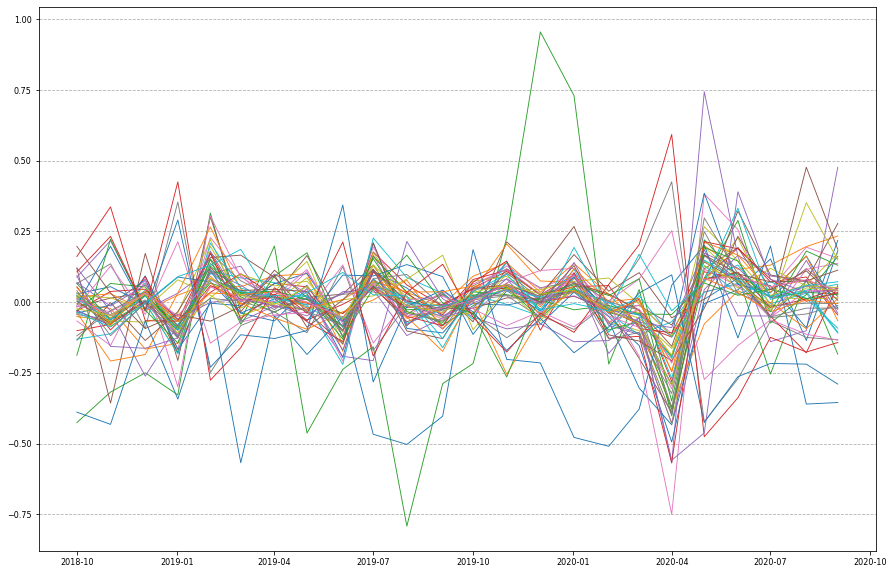

In [9]:
returns = np.c_[riskfree_rate*np.ones((num_steps,1)), risky_asset_returns.values[-num_steps:]]

plt.figure(figsize=(15,10))
plt.plot(risky_asset_returns.index[-36:-12], risky_asset_returns[-36:-12], linewidth=0.9)
plt.grid(axis='y', linestyle='--', linewidth=0.8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

#### Set model parameters

In [10]:
lambd = 0.001
omega = 1.0
beta = 1000.0
gamma = 0.95
eta = 1.5  # 1.3 # 1.5 # 1.2
rho = 0.4
reward_params = [lambd, omega, eta, rho]

#### Train the RL model while simulate trajectory via historical returns

In [11]:
returns_all = []
returns_all_equal = []
trajs = []
x_t = x_vals_init[:]
print(x_t)

[19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314 19.60784314
 19.60784314 19.60784314 19.60784314]


In [12]:
data_xvals = torch.zeros(num_steps, num_assets, dtype=torch.float64, requires_grad=False)
data_uvals = torch.zeros(num_steps, num_assets, dtype=torch.float64, requires_grad=False)
realized_rewards = torch.zeros(num_steps, dtype=torch.float64, requires_grad=False)
# realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)
realized_G_fun = torch.zeros(num_steps, dtype=torch.float64, requires_grad=False)
realized_F_fun = torch.zeros(num_steps, dtype=torch.float64, requires_grad=False)
# realized_G_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)
# realized_F_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)
for t in range(num_steps):
    expected_risky_returns[t:] = risky_asset_returns.iloc[-t_in-t_out+t:-t_out+t].mean().values

    # Create a G-learner
    G_learner = G_learning_portfolio_opt(num_steps,
                                         reward_params,
                                         beta,
                                         benchmark_portf,
                                         gamma,
                                         num_risky_assets,
                                         riskfree_rate,
                                         expected_risky_returns,  # array of shape num_steps x num_stocks
                                         Sigma_r,     # covariance matrix of returns of risky matrix
                                         x_vals_init,  # array of initial values of len (num_stocks+1)
                                         use_for_WM=True)  # use for wealth management tasks

    G_learner.reset_prior_policy()
    error_tol = 1.e-8
    max_iter_RL = 200
    G_learner.G_learning(error_tol, max_iter_RL)

    # Formula (39)
    mu_t = G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:].mv(torch.tensor(x_t))
    u_t = np.random.multivariate_normal(mu_t.detach().numpy(), G_learner.Sigma_prior[t,:].detach().numpy())
    # compute new values of x_t

    x_next = x_t + u_t

    x_next = (1+returns[t])*x_next
    port_returns = (x_next.sum() - x_t.sum() - np.sum(u_t) - 0.015*np.abs(u_t).sum())/x_t.sum()
    trajs.append((x_t, u_t))
    
    # compute the rewards and realized values of G- and F-functions from the trajectory
    data_xvals[t,:] = torch.tensor(trajs[t][0], dtype=torch.float64)
    data_uvals[t,:] = torch.tensor(trajs[t][1], dtype=torch.float64)
    realized_rewards[t] = G_learner.compute_reward_on_traj(t, data_xvals[t,:], data_uvals[t,:])
    realized_G_fun[t] = G_learner.compute_G_fun_on_traj(t, data_xvals[t,:], data_uvals[t,:])
    realized_F_fun[t] = G_learner.compute_F_fun_on_traj(t, data_xvals[t,:])
    
    # rename
    x_t = x_next
    returns_all.append(port_returns)
    returns_all_equal.append(returns[t].mean())
    # end the loop over time steps

In [13]:
print(expected_risky_returns)

[[-2.36609858e-02  3.99883372e-02 -8.32163916e-02  1.52580151e-02
   5.16127683e-03  7.04914312e-02  2.01331154e-02  8.03946687e-03
   7.69667159e-04  1.26798092e-02 -2.25019834e-03  4.03507425e-03
   3.07554791e-03  4.52401879e-03  2.16258491e-03 -3.30524793e-03
   2.11100059e-02 -3.60804065e-02  2.03297635e-02  4.26874707e-03
   1.91644610e-02 -2.87244029e-02  3.79093065e-03  1.56962147e-02
   7.38243176e-03  2.58356010e-02  8.24954659e-03 -7.74788481e-04
   3.47686561e-02  1.69759536e-02 -7.84343443e-02 -8.03608994e-04
   6.61429149e-03  1.43772266e-02  7.26412696e-03  2.29623883e-02
  -2.65176559e-02  5.25718379e-03  1.64172797e-02  1.32616018e-02
  -7.29710539e-02  5.71686224e-04  3.73300361e-02 -2.51777273e-02
  -8.49937146e-03  7.47336169e-03  4.56591072e-03 -5.75661488e-03
   4.98452909e-03  2.92360422e-02]
 [-2.62472219e-02  3.81221696e-02 -7.80324127e-02  1.04023837e-02
  -2.84900758e-03  6.92964689e-02  1.89746827e-02  4.71841555e-03
  -5.55472133e-03  9.53602593e-03 -2.2189

#### Calculate performance of G-learner

In [14]:
SR_G = (np.mean(returns_all)-riskfree_rate*dt)/np.std(returns_all)
SR_G_equal = (np.mean(returns_all_equal)-riskfree_rate*dt)/np.std(returns_all_equal)
print(SR_G)

r_G = np.array([0]*num_steps, dtype='float64')
r_G_equal = np.array([0]*num_steps, dtype='float64')
for i in range(num_steps):
    r_G[i] += returns_all[i]
    r_G_equal[i] += returns_all_equal[i]

0.487551605233545


Text(0.5, 0, 'time')

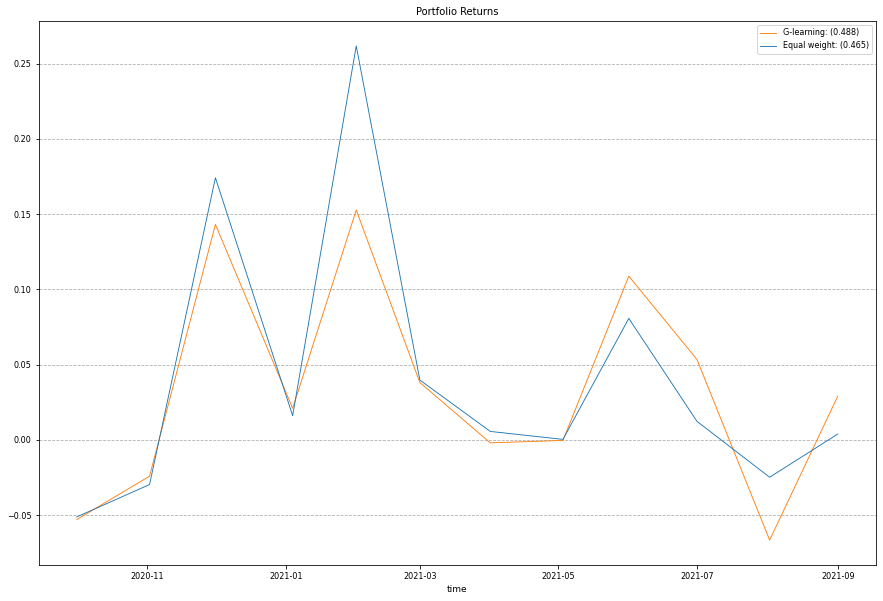

In [15]:
plt.figure(figsize=(15,10))
plt.plot(risky_asset_returns.index[-num_steps:], r_G, color='tab:orange', linewidth=0.9)
plt.plot(risky_asset_returns.index[-num_steps:], r_G_equal, color='tab:blue', linewidth=0.9)
plt.legend(
    ['G-learning: (' + str(np.round(SR_G, 3)) + ')',
     'Equal weight: (' + str(np.round(SR_G_equal, 3)) + ')'], fontsize=8
)
plt.grid(axis='y', linestyle='--', linewidth=0.8)
plt.title('Portfolio Returns', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('time', fontsize=9)

In [16]:
realized_cum_rewards = realized_rewards.sum()
realized_G_fun_cum = realized_G_fun.sum()
realized_F_fun_cum = realized_F_fun.sum()

Text(0.5, 1.0, 'Realized rewards')

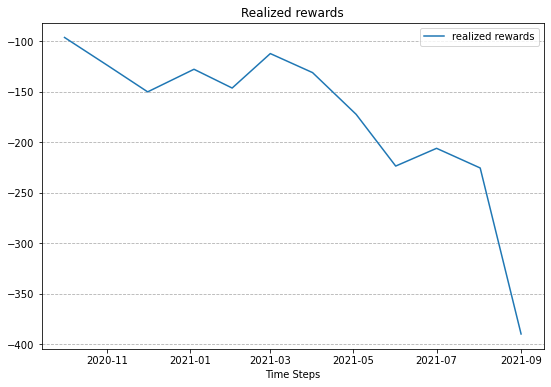

In [17]:
plt.figure(figsize=(9,6))
plt.plot(risky_asset_returns.index[-num_steps:], realized_rewards.detach().numpy(), label='realized rewards')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.8)
plt.xlabel('Time Steps')
plt.title('Realized rewards')

Text(0.5, 1.0, 'Optimal cash installment and portfolio value')

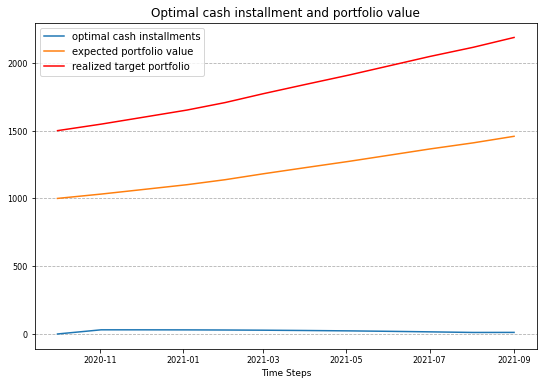

In [18]:
G_learner.project_cash_injections()

eta_ = G_learner.eta.detach().numpy()
realized_target_portf = eta_ * G_learner.expected_portf_val.numpy()

plt.figure(figsize=(9,6))
plt.plot(risky_asset_returns.index[-num_steps:], G_learner.expected_c_t, label='optimal cash installments')
plt.plot(risky_asset_returns.index[-num_steps:], G_learner.expected_portf_val, label='expected portfolio value')
plt.plot(risky_asset_returns.index[-num_steps:], realized_target_portf, label='realized target portfolio', color='r')

plt.grid(axis='y', linestyle='--', linewidth=0.8)
plt.legend()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Time Steps', fontsize=9)
plt.title('Optimal cash installment and portfolio value')

In [19]:
print('Optimal Cash Installments:')
G_learner.expected_c_t

Optimal Cash Installments:


tensor([ 0.0000, 30.6981, 30.6062, 30.1903, 29.2665, 27.8771, 25.6206, 22.8609,
        19.5772, 15.6815, 11.1595, 11.6162], dtype=torch.float64)